In [2]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
#import python package for working with cooler files: https://github.com/open2c/cooler
import cooler

In [4]:
# to plot ticks in terms of megabases we use the EngFormatter
# https://matplotlib.org/gallery/api/engineering_formatter.html

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [5]:
# to print which resolutions are stored in the mcool, use list_coolers
infile = '/public1/mowp/workspace/mowp_scripts/pipelines/hic_pipeline/hindIII_hic_SRR1504819.hic.q1.resolution_1000.mcool'
cooler.fileops.list_coolers(infile)

['/resolutions/1000',
 '/resolutions/2000',
 '/resolutions/5000',
 '/resolutions/10000',
 '/resolutions/25000',
 '/resolutions/50000',
 '/resolutions/100000',
 '/resolutions/250000',
 '/resolutions/500000',
 '/resolutions/1000000',
 '/resolutions/2500000',
 '/resolutions/5000000',
 '/resolutions/10000000']

# Visualization

https://cooltools.readthedocs.io/en/latest/notebooks/viz.html

## Plotting raw counts

In [7]:
### to load a cooler with a specific resolution use the following syntax:
clr = cooler.Cooler(infile+'::resolutions/1000000')

### to print chromosomes and binsize for this cooler
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
chromends = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])
    chromends.append(clr.extent(i)[1])
chromstarts.append(clr.extent(i)[1])

chromosomes: ['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5'], binsize: 1000000
Chr1 : (0, 33)
Chr2 : (33, 56)
Chr3 : (56, 82)
Chr4 : (82, 104)
Chr5 : (104, 134)


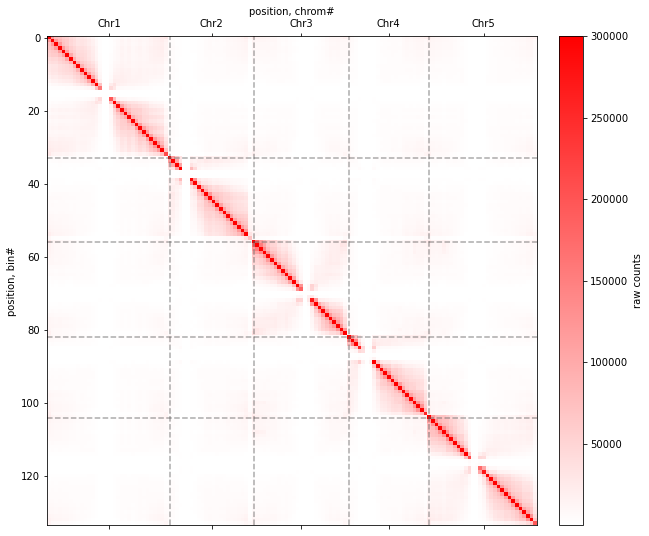

In [8]:
f, ax = plt.subplots(figsize=(10, 9))

fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)
im = ax.matshow((clr.matrix(balance=False)[:]), cmap=fruitpunch, vmax=3*1e5)
plt.colorbar(im, fraction=0.046, pad=0.04, label='raw counts')

chroms = [(chromstarts[i]+chromstarts[i+1])/2 for i in range(len(chromstarts)-1)]
ax.set(xticks=chroms,
       xticklabels=clr.chromnames,
       xlabel='position, chrom#',
       ylabel='position, bin#')
ax.xaxis.set_label_position('top')
for i in chromends[:-1]:
    ax.axvline(i, color='#555555', ls='--', alpha=.5)
    ax.axhline(i, color='#555555', ls='--', alpha=.5)

## Logarithmic color scale

Since C data has a high dynamic range, we often plot the data in log-scale. This enables simultaneous visualization of features near and far from the diagonal in a consistent colorscale. Note that regions with no reported counts are evident as white stripes at both centromeres. This occurs because reads are not uniquely mapped to these highly-repetitive regions. These regions are masked before matrix balancing.

In [60]:
def get_chrom_ticks_pos(clr):
    chromstarts = []
    chromends = []
    for i in clr.chromnames:
        chromstarts.append(clr.extent(i)[0])
        chromends.append(clr.extent(i)[1])
    chromstarts.append(clr.extent(i)[1])
    chroms = [(chromstarts[i]+chromstarts[i+1])/2 for i in range(len(chromstarts)-1)]

    return chroms

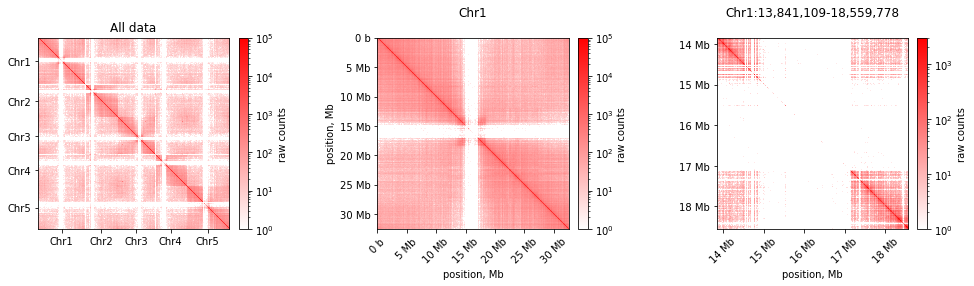

In [61]:
# plot heatmaps at megabase resolution with 3 levels of zoom in log-scale with a consistent colormap#
from matplotlib.colors import LogNorm

infile = '/public1/mowp/workspace/mowp_scripts/pipelines/hic_pipeline/hindIII_hic_SRR1504819.hic.q1.resolution_1000.mcool'

f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)
bp_formatter = EngFormatter('b')

fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

# ax0
clr = cooler.Cooler(infile+'::resolutions/50000')
norm = LogNorm(vmax=1e5)

chroms_pos = get_chrom_ticks_pos(clr)

ax = axs[0]
im = ax.matshow(
    clr.matrix(balance=False)[:],
    norm=norm,
    cmap=fruitpunch
)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chroms_pos)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chroms_pos)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

# ax1
ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('Chr1'),
    norm=norm,
    extent=(0,clr.chromsizes['Chr1'], clr.chromsizes['Chr1'], 0),
    cmap=fruitpunch
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('Chr1', y=1.08)
ax.set(ylabel='position, Mb', xlabel='position, Mb')
format_ticks(ax)

# ax2
clr = cooler.Cooler(infile+'::resolutions/10000')
norm = LogNorm(vmax=3000)

ax = axs[2]
start, end = 14_841_109-1_000_000, 17_559_778+1_000_000
region = ('Chr1', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    norm = norm,
    extent=(start, end, end, start),
    cmap=fruitpunch,
);
ax.set_title(f'Chr1:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set(xlabel='position, Mb')
format_ticks(ax)
plt.tight_layout()